In [1]:
import pandas as pd
import numpy as np
import string
import scipy as sp
from math import ceil
import seaborn as sns
from glob import glob
from Bio import pairwise2, SeqIO, Seq
import ternary
from matplotlib_venn import venn2_unweighted, venn3, venn3_circles, venn3_unweighted
import gffpandas.gffpandas as gffpd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import copy
import pycircos
from Bio.SeqUtils import GC
import textwrap
import math
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker

sns.set_context(rc = {'legend.fontsize': 8, 'ytick.labelsize': 8, 'xtick.labelsize':8, 'axes.labelsize':8})
matplotlib.rcParams["font.family"] = "Arial"

primary = '#33B9CB'
secondary = '#6A994E'
tertiary = '#F5911F'

OUT_DIR = '../../02-OUTPUT/06-ANALYSIS'
ortho_df = pd.read_csv('../../02-OUTPUT/05-PIRATE/orthologous_clustering.csv')
optimized_df = pd.read_csv(f'{OUT_DIR}/tss_df.csv').query('dataset == "optimized"')
operon_df = pd.read_csv(f'{OUT_DIR}/operon_df.csv')

In [2]:
ortho_df = pd.read_csv('../../02-OUTPUT/05-PIRATE/PIRATE.gene_families.ordered.originalIDs.tsv',sep='\t')
species_cols = [i for i, col in enumerate(ortho_df.columns) if "AS2I3" in col or "C58" in col or "AS1D4" in col]
species = [col for i, col in enumerate(ortho_df.columns) if "AS2I3" in col or "C58" in col or "AS1D4" in col]
col_select = list(range(22)) + species_cols
ortho_df = ortho_df.iloc[:,col_select]
ortho_df = ortho_df.dropna(subset=species)
ortho_df = ortho_df.rename(columns={'Agrobacterium_fabrum_str_C58':'BV1','AS2I3':'BV2','AS1D4':'BV3'})
ortho_df['BV3'] = ortho_df['BV3'].apply(lambda x: x.replace('.p01',''))
ortho_df['BV2'] = ortho_df['BV2'].apply(lambda x: x.replace('.p01',''))
ortho_df['BV1'] = ortho_df['BV1'].apply(lambda x: x.replace('(','').replace(':',';').replace(')',''))
ortho_df['BV2'] = ortho_df['BV2'].apply(lambda x: x.replace('(','').replace(':',';').replace(')',''))
ortho_df['BV3'] = ortho_df['BV3'].apply(lambda x: x.replace('(','').replace(':',';').replace(')',''))
ortho_df['BV1'] = ortho_df['BV1'].apply(lambda x: x.split(';'))
ortho_df['BV2'] = ortho_df['BV2'].apply(lambda x: x.split(';'))
ortho_df['BV3'] = ortho_df['BV3'].apply(lambda x: x.split(';'))
ortho_df = ortho_df.explode('BV1')
ortho_df = ortho_df.explode('BV2')
ortho_df = ortho_df.explode('BV3')
ortho_df.to_csv('../../02-OUTPUT/05-PIRATE/orthologous_clustering.csv',index=False)


/tmp/ipykernel_209117/4196609083.py:1: DtypeWarning: Columns (2,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,27

In [3]:

optimized_df = pd.read_csv('../../02-OUTPUT/04-TSS/optimized_tss.csv')
primary_df = optimized_df[ ~optimized_df['Sequence -50 nt upstream + TSS (51nt)'].isna() ].query('TSS_class == "primary"').copy()

overlap_df = ortho_df.merge(primary_df.add_prefix('BV1_'),left_on='BV1',right_on='BV1_Locus_tag',how='outer',indicator=True).copy().rename(columns={'_merge':'BV1_merge'})
overlap_df = overlap_df.merge(primary_df.add_prefix('BV2_'),left_on='BV2',right_on='BV2_Locus_tag',how='outer',indicator=True).rename(columns={'_merge':'BV2_merge'})
overlap_df = overlap_df.merge(primary_df.add_prefix('BV3_'),left_on='BV3',right_on='BV3_Locus_tag',how='outer',indicator=True).rename(columns={'_merge':'BV3_merge'})
overlap_df['in_BV1'] = overlap_df.apply(lambda row: not pd.isna(row['BV1_Locus_tag']) and pd.isna(row['BV2_Locus_tag']) and pd.isna(row['BV3_Locus_tag']), axis=1)
overlap_df['in_BV2'] = overlap_df.apply(lambda row: pd.isna(row['BV1_Locus_tag']) and not pd.isna(row['BV2_Locus_tag']) and pd.isna(row['BV3_Locus_tag']), axis=1)
overlap_df['in_BV3'] = overlap_df.apply(lambda row: pd.isna(row['BV1_Locus_tag']) and pd.isna(row['BV2_Locus_tag']) and not pd.isna(row['BV3_Locus_tag']), axis=1)
overlap_df['in_BV1_BV2'] = overlap_df.apply(lambda row: not pd.isna(row['BV1_Locus_tag']) and not pd.isna(row['BV2_Locus_tag']) and pd.isna(row['BV3_Locus_tag']), axis=1)
overlap_df['in_BV1_BV3'] = overlap_df.apply(lambda row: not pd.isna(row['BV1_Locus_tag']) and not pd.isna(row['BV3_Locus_tag']) and pd.isna(row['BV2_Locus_tag']), axis=1)
overlap_df['in_BV2_BV3'] = overlap_df.apply(lambda row: not pd.isna(row['BV2_Locus_tag']) and not pd.isna(row['BV3_Locus_tag']) and pd.isna(row['BV1_Locus_tag']), axis=1)
overlap_df['in_BV1_BV2_BV3'] = overlap_df.apply(lambda row: not pd.isna(row['BV1_Locus_tag']) and not pd.isna(row['BV2_Locus_tag']) and not pd.isna(row['BV3_Locus_tag']), axis=1)
overlap_df = overlap_df.drop_duplicates(subset='allele_name')
overlap_df.to_csv('../../02-OUTPUT/05-PIRATE/ortho_primary_tss.csv')



/tmp/ipykernel_209117/698887077.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(f'{OUT_DIR}/08-fig4.png',dpi=300,transparent=True,bbox_inches='tight')


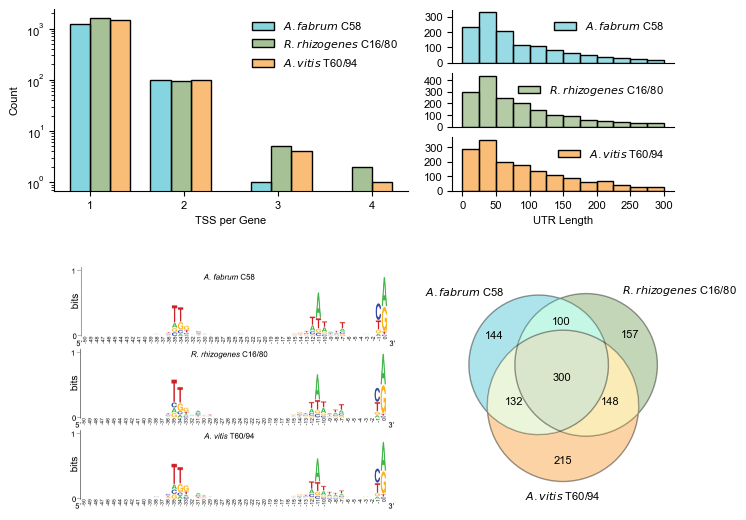

In [8]:
fig = plt.figure(tight_layout=True,figsize=(8,6.5))
gs = gridspec.GridSpec(8,4,wspace=-0.4)


tmp = optimized_df.query('TSS_class == "primary" or TSS_class == "secondary"').drop_duplicates(subset=['contig','SuperPos','SuperStrand']).groupby(['biovar','Locus_tag']).count().reset_index()
tmp['biovar_name'] = tmp['biovar'].map({'BV1':r'$\it{A. fabrum}$ C58','BV2':r'$\it{R. rhizogenes}$ C16/80','BV3':r'$\it{A. vitis}$ T60/94'})
g = sns.histplot(data=tmp,x='SuperPos',hue='biovar_name',multiple='dodge',shrink=3,alpha=0.6,palette=[primary,secondary,tertiary],ax=fig.add_subplot(gs[0:3, 0:2]))
g.legend_.set_title(None)
g.legend_.set_frame_on(False)
g.set_yscale('log')
g.set_xticks(range(1,5))
# g.set_xlabel('Primary or Secondary TSS per Gene')
g.set_xlabel('TSS per Gene')
sns.despine()

tmp = optimized_df.copy()
tmp['biovar_name'] = tmp['biovar'].map({'BV1':r'$\it{A. fabrum}$ C58','BV2':r'$\it{R. rhizogenes}$ C16/80','BV3':r'$\it{A. vitis}$ T60/94'})
g = sns.histplot(data=tmp.query('TSS_class == "primary" and biovar =="BV1"'),x='UTRlength',hue='biovar_name',multiple='dodge',alpha=0.5,palette=[primary],bins=list(range(0,325,25)),ax=fig.add_subplot(gs[0, 3:]))
g.legend_.set_title(None)
g.legend_.set_frame_on(False)
g.set_xticklabels([])
g.tick_params(bottom=False)
g.yaxis.set_major_locator(ticker.MultipleLocator(100))
g.set_ylabel(None)
g.set_xlabel(None)
sns.despine()
g = sns.histplot(data=tmp.query('TSS_class == "primary" and biovar =="BV2"'),x='UTRlength',hue='biovar_name',multiple='dodge',alpha=0.5,palette=[secondary],bins=list(range(0,325,25)),ax=fig.add_subplot(gs[1, 3:]))
g.legend_.set_title(None)
g.legend_.set_frame_on(False)
g.set_xticklabels([])
g.tick_params(bottom=False)
g.set_ylabel(None)
g.set_xlabel(None)
g.yaxis.set_major_locator(ticker.MultipleLocator(100))
sns.despine()
g = sns.histplot(data=tmp.query('TSS_class == "primary" and biovar =="BV3"'),x='UTRlength',hue='biovar_name',multiple='dodge',alpha=0.6,palette=[tertiary],bins=list(range(0,325,25)),ax=fig.add_subplot(gs[2, 3:]))
g.legend_.set_title(None)
g.legend_.set_frame_on(False)
g.yaxis.set_major_locator(ticker.MultipleLocator(100))
g.xaxis.set_major_locator(ticker.MultipleLocator(50))
g.set_ylabel(None)
g.set_xlabel('UTR Length')
sns.despine()

ax = fig.add_subplot(gs[4:, 0:2])
ax.imshow(plt.imread(f'{OUT_DIR}/promoters.png'))
ax.axis('off')

# font2 = {'family': 'Comic Sans MS', 'size': 8.5} # use for labels
# plt.rc('font', **font2)
v = venn3(subsets = (overlap_df['in_BV1'].sum(), overlap_df['in_BV2'].sum(), overlap_df['in_BV1_BV2'].sum(), overlap_df['in_BV3'].sum(), overlap_df['in_BV1_BV3'].sum(), overlap_df['in_BV2_BV3'].sum(), overlap_df['in_BV1_BV2_BV3'].sum()), 
        set_labels = (r'$\it{A. fabrum}$ C58', r'$\it{R. rhizogenes}$ C16/80', r'$\it{A. vitis}$ T60/94'), 
        set_colors=[primary,secondary,tertiary],
        ax=fig.add_subplot(gs[4:, 3:4]))
for i in range(len(v.patches)):
    if i in [0,1,3,6,7]:
        patch = v.patches[i]
        patch.set_edgecolor("black")
        patch.set_lw(1)
for text in v.set_labels:
    text.set_fontsize(8)
for x in range(len(v.subset_labels)):
    if v.subset_labels[x] is not None:
        v.subset_labels[x].set_fontsize(8)

fig.savefig(f'{OUT_DIR}/08-fig4.png',dpi=300,transparent=True,bbox_inches='tight')
plt.show()


# conserved antisense TSS across BV


In [ ]:
tss_df.query('TSS_class == "antisense" and TSS_locus_tag != "orphan"').copy()


In [ ]:
antisense_df = tss_df.query('TSS_class == "antisense" and TSS_locus_tag != "orphan"').copy().rename(columns={'TSS_locus_tag':'locus_tag'})
overlap_df = ortho_df.merge(antisense_df.query('biovar == "BV1"').add_prefix('BV1_'),left_on='BV1',right_on='BV1_locus_tag').copy().rename(columns={'_merge':'BV1_merge'})
overlap_df = overlap_df.merge(antisense_df.query('biovar == "BV2"').add_prefix('BV2_'),left_on='BV2',right_on='BV2_locus_tag').rename(columns={'_merge':'BV2_merge'})
overlap_df = overlap_df.merge(antisense_df.query('biovar == "BV3"').add_prefix('BV3_'),left_on='BV3',right_on='BV3_locus_tag').rename(columns={'_merge':'BV3_merge'})
overlap_df = overlap_df.drop_duplicates(subset='allele_name').drop(columns=['products'])
overlap_df.style

# map operon + tss data to orthologous cluster

In [ ]:
merged_df = operon_df.merge(tss_df,left_on=['biovar','ID'],right_on=['biovar','TSS_locus_tag'])
merged_df
# merged_df = merged_df[['start','end','strand','ID','gene_count','operon_id','biovar','Pos','TSS_class','Sequence -50 nt upstream + TSS (51nt)','contig']]
# merged_df = merged_df.rename(columns={
#     'start':'operon_start',
#     'end':'operon_end',
#     'strand':'operon_strand',
#     'gene_count':'operon_gene_count',
#     'Pos':'TSS_pos',
#     'ID': 'TSS_locus_tag',
#     'Sequence -50 nt upstream + TSS (51nt)':'TSS_promoter'
# })
# ortho_df = ortho_df[['consensus_gene_name','consensus_product','threshold','BV3','BV2','BV1']]


In [ ]:
# ID_operonID = dict(zip(operon_df['ID'],operon_df['operon_id']))
# ortho_df['BV2_operon_id'] = ortho_df['BV2'].map(ID_operonID)
# ortho_df['BV3_operon_id'] = ortho_df['BV3'].map(ID_operonID)
# merged_df['operon_id'] = merged_df['TSS_locus_tag'].map(ID_operonID)

# ortho_df.merge(merged_df.query('biovar == "BV2"'), left_on='BV2_operon_id', right_on='operon_id',indicator=True,prefix).merge(merged_df.query('biovar == "BV3"'), left_on='BV2_operon_id', right_on='operon_id')
# ortho_df.sort_values('BV2_operon_id').tail(100).style
